In [1]:
import rmgpy
from rmgpy import chemkin
import numpy as np
from copy import deepcopy
import csv
from rmgpy.molecule.molecule import *
from rmgpy.species import *
from rmgpy.chemkin import *
import rmgpy.kinetics as _kinetics
from rmgpy.data.rmg import RMGDatabase
from IPython.display import display
from rmgpy.data.thermo import ThermoLibrary
from rmgpy.rmg.react import react
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.data.rmg import get_db
from rmgpy.exceptions import UndeterminableKineticsError, ActionError
from rmgpy.data.base import LogicOr
from itertools import product
from rmgpy.molecule.group import Group
from rmgpy.kinetics.arrhenius import ArrheniusBM
import time
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [2]:
from rmgpy import settings


In [3]:
settings


{'database.directory': '/Users/rwest/Code/RMG-database/input',
 'test_data.directory': '/Users/rwest/Code/RMG-Py/rmgpy/test_data'}

In [4]:
database = RMGDatabase()
database.load(
            path = settings['database.directory'],
            thermo_libraries = ['Klippenstein_Glarborg2016', 'BurkeH2O2', 'thermo_DFT_CCSDTF12_BAC', 
                               'DFT_QCI_thermo',
                           'primaryThermoLibrary', 'primaryNS', 'NitrogenCurran', 'NOx2018', 'FFCM1(-)',
'SulfurLibrary', 'SulfurGlarborgH2S','SABIC_aromatics'],
            transport_libraries = [],
            reaction_libraries = [],
            seed_mechanisms = [],#['BurkeH2O2inN2','ERC-FoundationFuelv0.9'],
            kinetics_families = 'all',
            kinetics_depositories = ['training'],
            #frequenciesLibraries = self.statmechLibraries,
            depository = False, # Don't bother loading the depository information, as we don't use it
        )


In [5]:
family = database.kinetics.families["Singlet_Carbene_Intra_Disproportionation"]


In [6]:
family.clean_tree()

In [7]:
start = time.time()
family.generate_tree(thermo_database=database.thermo)
end = time.time()
print(end-start)

ERROR:root:4.0


13.651165008544922


In [8]:
len(family.groups.entries)

7

In [9]:
family.groups.entries

{'CH_C_unsaturated': <Entry index=-1 label="CH_C_unsaturated">,
 'Root': <Entry index=0 label="Root">,
 'Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C': <Entry index=1 label="Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C">,
 'Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C': <Entry index=2 label="Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C">,
 'Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C_Ext-4R!H-R_Ext-4R!H-R': <Entry index=3 label="Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C_Ext-4R!H-R_Ext-4R!H-R">,
 'Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_Sp-6R!H-5R!H': <Entry index=4 label="Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_Sp-6R!H-5R!H">,
 'Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-6R!H-5R!H': <Entry index=5 label="Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-6R!H-5R!H">}

In [10]:
start = time.time()
family.check_tree()
end = time.time()
print(end-start)

0.0001671314239501953


In [11]:
start = time.time()
family.regularize(thermo_database=database.thermo)
end = time.time()
print(end-start)

0.11703705787658691


In [12]:
start = time.time()
templateRxnMap = family.get_reaction_matches(thermo_database=database.thermo,remove_degeneracy=True,
                                             get_reverse=True,exact_matches_only=False,fix_labels=True)
end = time.time()
print(end-start)

0.11816763877868652


In [13]:
len(templateRxnMap)

7

In [14]:
family.clean_tree_rules()

In [15]:
start = time.time()
family.make_bm_rules_from_template_rxn_map(templateRxnMap)#,nprocs=6)
end = time.time()
print(end-start)

/Users/rwest/opt/anaconda3/envs/rmgob3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/rwest/opt/anaconda3/envs/rmgob3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rwest/opt/anaconda3/envs/rmgob3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.19691801071166992


In [16]:
start = time.time()
family.check_tree()
end = time.time()
print(end-start)

0.00040602684020996094


In [17]:
start = time.time()
errors,uncertainties = family.cross_validate(iters=0,random_state=5,folds=0,ascend=False)
end = time.time()
print(end-start)

0.1305232048034668


In [18]:
errors.values()

dict_values([0.8030504029195975, -4.24816118414446, -4.132982378327092, 4.255787116200998])

Text(0.5, 0, '$|Ln(k_{est}/k_{rxn})|$')

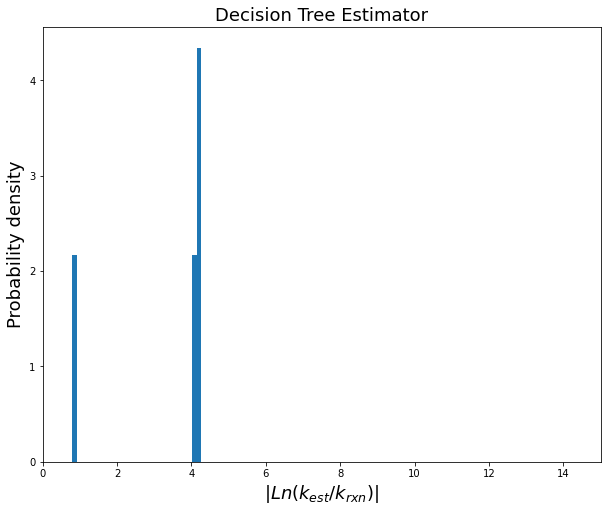

In [19]:
plt.figure(figsize=(10,8))
plt.hist(np.abs(list(errors.values())),bins=30, density=True)
plt.title('Decision Tree Estimator',fontsize=18)
#plt.ylim(0,.4)
plt.xlim(0,15)
plt.ylabel('Probability density',fontsize=18)
plt.xlabel(r'$|Ln(k_{est}/k_{rxn})|$',fontsize=18)

In [20]:
#family.save('/Users/mattjohnson/RMGCODE/RMG-database/input/kinetics/families/')

In [21]:
save_path = os.path.join(settings['database.directory'], 'kinetics', 'families', family.name)
print(save_path)

/Users/rwest/Code/RMG-database/input/kinetics/families/Singlet_Carbene_Intra_Disproportionation


In [22]:
family.save(save_path)